In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


In [103]:
dataset = pd.read_csv('/content/housing.csv')   # path to your csv file
# drop any incomplete enteries
dataset = dataset.dropna()
#iew the first five rows of the dataset
print(" here are the first five rows")
dataset.head(10)

 here are the first five rows


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [0]:
#Next we will split the report dataset into input x and output Y
Y = dataset['median_house_value']  # we will predict the median house value column
# the remainder of the coumns will be used to predict Y
# Select from the  longitude column to the 'median_income' column
X= dataset.loc[:,'longitude':'median_income']

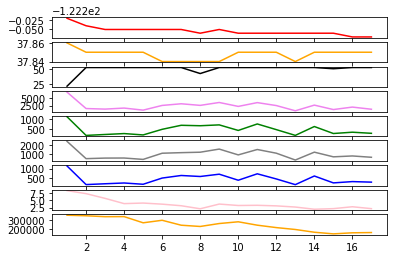

In [105]:
%matplotlib inline

f1=X['longitude'][1:18]
f2 = X['latitude'][1:18]
f3=X['housing_median_age'][1:18]
f4 = X['total_rooms'][1:18]
f5=X['total_bedrooms'][1:18]
f6 = X['population'][1:18]
f7=X['households'][1:18]
f8 = X['median_income'][1:18]
f9 = Y[:][1:18]

plt.figure()
plt.subplot(9,1,1)
plt.plot(f1 , 'red')
plt.subplot(9,1,2 )
plt.plot(f2, 'orange')

plt.subplot(9,1,3)
plt.plot(f3, 'black')
plt.subplot(9,1,4 )
plt.plot(f4, 'violet')

plt.subplot(9,1,5)
plt.plot(f5, 'green')
plt.subplot(9,1,6 )
plt.plot(f6,'gray')

plt.subplot(9,1,7)
plt.plot(f7,'blue')
plt.subplot(9,1,8 )
plt.plot(f8,'pink')
plt.subplot(9,1,9)
plt.plot(f9,'orange')


In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 2003)
x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()
#convert the testing data
x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

In [0]:
import torch

from torch.nn import Conv1d #convolution layer

from torch.nn import MaxPool1d # max pooling layer

from torch.nn import Flatten #flatten layer

from torch.nn import Linear  #linear layer

from torch.nn.functional import relu #reLU activation function

from torch.utils.data import DataLoader, TensorDataset 


In [0]:
class CnnRegressor(torch.nn.Module):
  #define the initialization method
  def __init__(self, batch_size, inputs, outputs):
    # initialize the superclass and store the paramteers
    super(CnnRegressor, self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    print(self.inputs)
    self.outputs = outputs

    #define the input layer
    #( input channels, output channels, kernel size)
    self.input_layer = Conv1d(inputs, batch_size, 1)
    
    # Define a max pooling layer
    self.conv_layer = Conv1d(batch_size, 128, 1)
    self.max_pooling_layer = MaxPool1d(1)

    self.conv_layer2 = Conv1d(128, 64, 1)
    
    self.max_pooling_layer2 = MaxPool1d(1)

    
    self.flatten_layer = Flatten()

    self.linear_layer = Linear(128, 64)

    self.output_layer = Linear(64, outputs)


    

  
  
  def feed(self, input):
    input = input.reshape((self.batch_size, self.inputs, 1))

    output = relu(self.input_layer(input))

    output = self.max_pooling_layer(output)
    
    output = relu(self.conv_layer(output))

    output = self.max_pooling_layer(output)
    
    output = self.flatten_layer(output)

    output = self.linear_layer(output)
    
    output = self.output_layer(output)


    return output



In [109]:
from torch.optim import SGD
from torch.nn import L1Loss
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

In [114]:
batch_size = 128
# (batch_size, X columns, Y columns)
model = CnnRegressor(batch_size, X.shape[1], 1)
#set the model to use the cpu for processing
model.cuda()

8


CnnRegressor(
  (input_layer): Conv1d(8, 128, kernel_size=(1,), stride=(1,))
  (conv_layer): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer2): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
  (max_pooling_layer2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
def model_loss(model, dataset, train = False, optimizer = True):
  performance = L1Loss()
  score_metric = R2Score()

  avg_loss = 0
  avg_score = 0
  count = 0

  for input, output in iter(dataset):
    predictions = model.feed(input)

    loss = performance(predictions, output)
    score_metric.update([predictions, output])
    score = score_metric.compute()

    if(train):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    avg_loss += loss.item()
    avg_score += score
    count += 1
  return avg_loss/count, avg_score/count

In [116]:
model.load_state_dict(torch.load('1107159_1dconv reg.pt'))

<All keys matched successfully>

In [117]:
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1)).cuda().float()
tensor = TensorDataset(inputs,outputs)
loader = DataLoader(tensor, batch_size, shuffle=True,drop_last=True)

avg_loss, avg_r2_score = model_loss(model, loader)
print( " the model's l1 loss is:"+ str(avg_loss))
print("the models avg r^2 score is:" +str(avg_r2_score))

 the model's l1 loss is:57811.108543882976
the models avg r^2 score is:0.5488963624891263
